In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from statsmodels.tsa.stattools import adfuller
import tensorflow
from tensorflow import keras
from keras import callbacks
from sklearn.metrics import mean_squared_error

# Load Dataset

In [32]:
data = pd.read_csv("/content/drive/MyDrive/traffic-dataset.csv")
data = data.drop(['Junction', 'ID'], axis=1)
data.head()

,Unnamed: 0,DateTime,Vehicles
0,0,2015-11-01 00:00:00,15
1,1,2015-11-01 01:00:00,13
2,2,2015-11-01 02:00:00,10
3,3,2015-11-01 03:00:00,7
4,4,2015-11-01 04:00:00,9


In [33]:
data = data.drop(columns=['Unnamed: 0'])
data.head()

,DateTime,Vehicles
0,2015-11-01 00:00:00,15
1,2015-11-01 01:00:00,13
2,2015-11-01 02:00:00,10
3,2015-11-01 03:00:00,7
4,2015-11-01 04:00:00,9


# Data Exploration

In [34]:
data["DateTime"]= pd.to_datetime(data["DateTime"])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14592 entries, 0 to 14591
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  14592 non-null  datetime64[ns]
 1   Vehicles  14592 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 228.1 KB


Text(0.5, 0, 'Tanggal bulan')

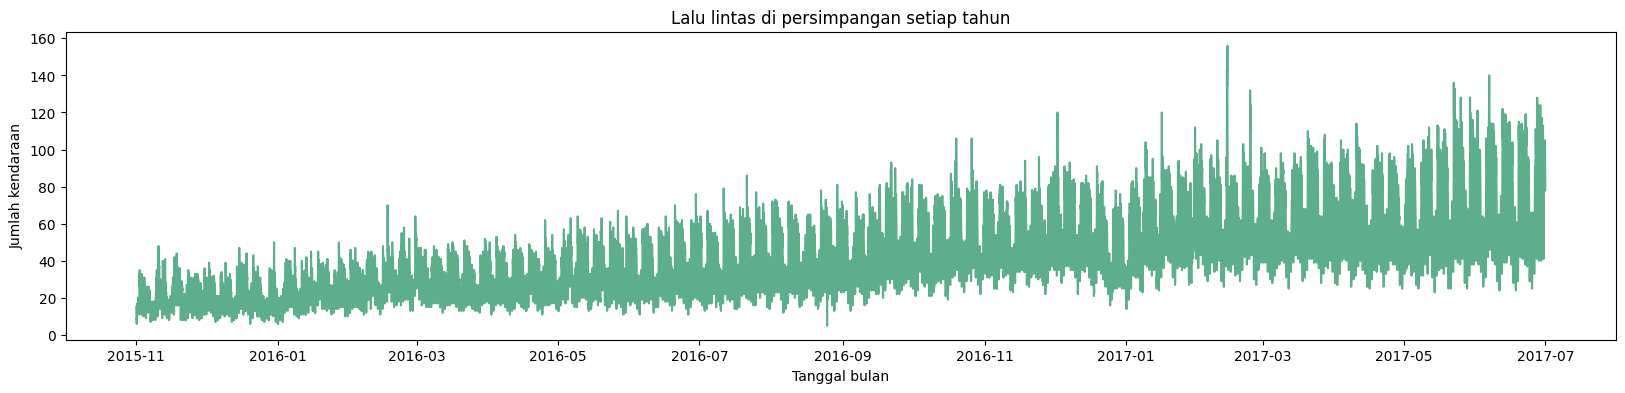

In [35]:
# plot time series
plt.figure(figsize=(20,4))
time_series = sns.lineplot(x=data['DateTime'], y="Vehicles", data=data, color="#5DAE8B")
time_series.set_title("Lalu lintas di persimpangan setiap tahun")
time_series.set_ylabel("Jumlah kendaraan")
time_series.set_xlabel("Tanggal bulan")

Berdasarkan hasil plotting, dataset tidak bersifat stationary sehingga perlu dilakukan transformasi. Pada penelitian ini, teknik transformasi yang digunakan adalah normalize dan differencing.

# Data Transformation and preprocessing


In [36]:
df = data.set_index("DateTime")
df

,Vehicles
DateTime,
2015-11-01 00:00:00,15
2015-11-01 01:00:00,13
2015-11-01 02:00:00,10
2015-11-01 03:00:00,7
2015-11-01 04:00:00,9
...,...
2017-06-30 19:00:00,105
2017-06-30 20:00:00,96
2017-06-30 21:00:00,90


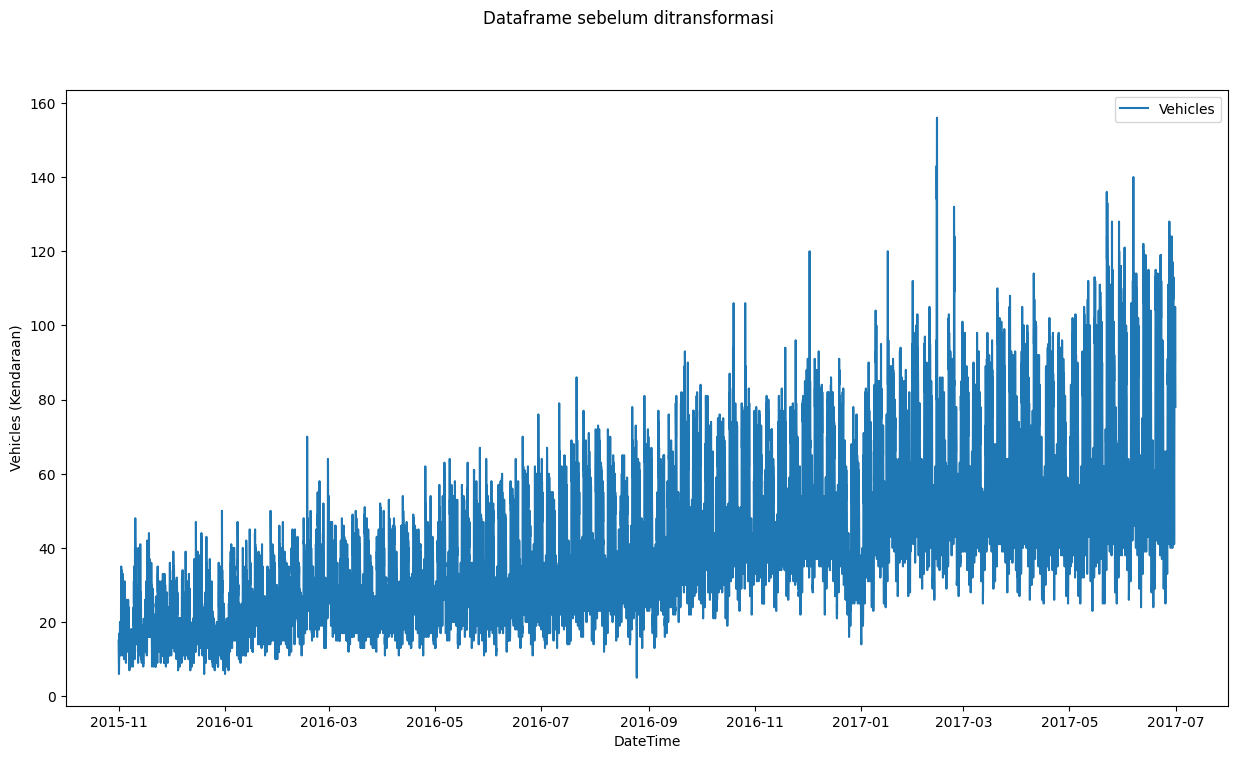

In [37]:
# plottings sebelum transformasi
def plot(data, condition):
  fig, ax = plt.subplots(figsize=(15, 8), sharey=True)
  fig.suptitle(f'Dataframe {condition} ditransformasi')
  pl_1=sns.lineplot(ax=ax, data=data, color="#5DAE8B")
  ax.set(ylabel ="Vehicles (Kendaraan)")

plot(df, "sebelum")

In [38]:
# transformasi
def Normalize(df,col):
    average = df[col].mean()
    stdev = df[col].std()
    df_normalized = (df[col] - average) / stdev
    df_normalized = df_normalized.to_frame()
    return df_normalized, average, stdev

def Difference(df,col, interval):
    diff = []
    for i in range(interval, len(df)):
        value = df[col][i] - df[col][i - interval]
        diff.append(value)
    return diff

In [39]:
df_normalized, average, stdev = Normalize(df, "Vehicles")
diff = Difference(df_normalized, col="Vehicles", interval=(24*7)) # interval per 1 minggu
df_normalized = df_normalized[24*7:]
df_normalized.columns = ["Norm"]
df_normalized["Diff"]= diff

<ipython-input-39-cad380ab83ca>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_normalized["Diff"]= diff


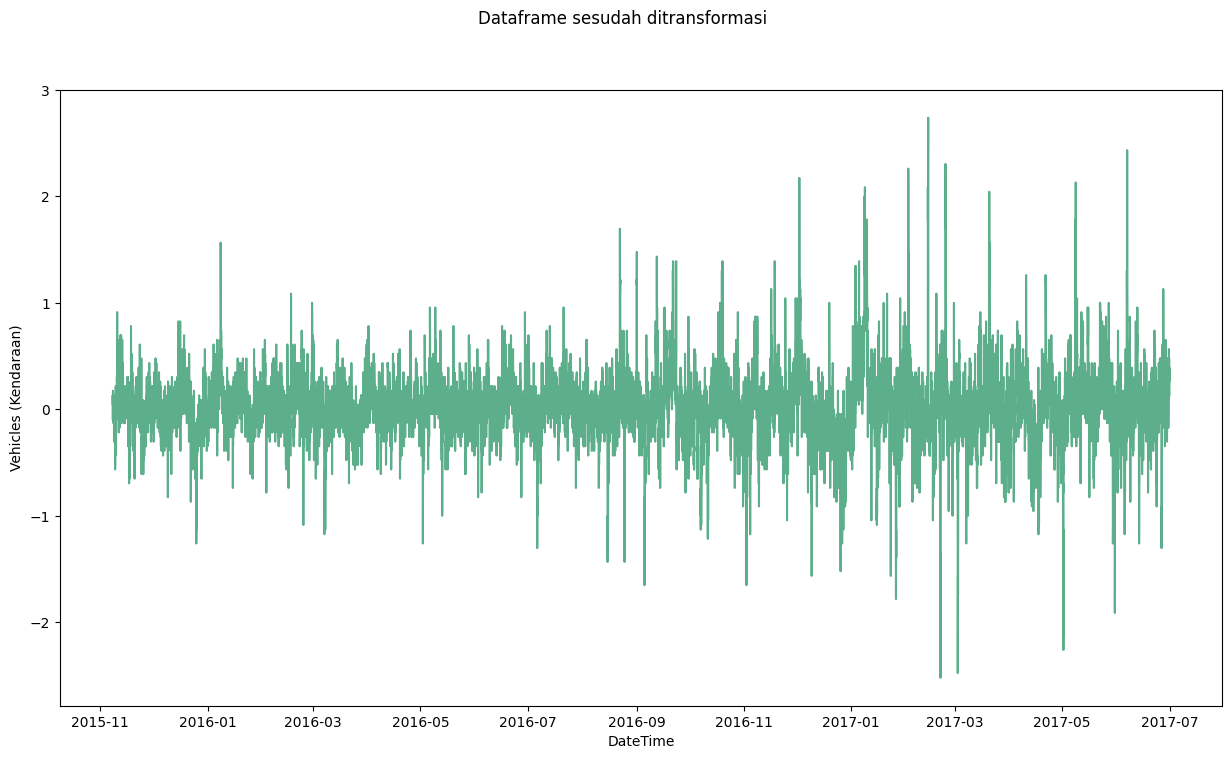

In [40]:
# plotting sesudah transformasi
plot(df_normalized.Diff, "sesudah")

Cek untuk memastikan apakah time series sudah stationary menggunakan Augmented Dickey Fuller test

In [41]:
def stationary_check(df):
    check = adfuller(df.dropna())
    print(f"ADF Statistic: {check[0]}")
    print(f"p-value: {check[1]}")
    print("Critical Values:")
    for key, value in check[4].items():
        print('\t%s: %.3f' % (key, value))
    if check[0] > check[4]["1%"]:
        print("Time series is non-stationary")
    else:
        print("Time series is stationary")

stationary_check(df_normalized.Diff)

ADF Statistic: -15.265303390415337
p-value: 4.79853987639816e-28
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time series is stationary


# Data Splitting

In [42]:
# proses difference menciptakan beberapa NA values karena interval per 1 minggu
df = df_normalized["Diff"].dropna()
df = df.to_frame()

def Split_data(df):
    training_size = int(len(df) * 0.8)
    data_len = len(df)
    train, test = df[0:training_size], df[training_size:data_len]
    train, test = train.values.reshape(-1, 1), test.values.reshape(-1, 1)
    return train, test

ds_train, ds_test = Split_data(df)

# mengubah bentuk data menjadi sequence
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# memperbaiki shape X_test and X_train
def fix_shape(train, test):
    train = np.reshape(train, (train.shape[0], train.shape[1], 1))
    test = np.reshape(test, (test.shape[0],test.shape[1],1))
    return train, test

In [43]:
X_train, y_train = create_sequences(ds_train, 32)
X_test, y_test = create_sequences(ds_test, 32)

In [44]:
X_train

array([[[-0.08692498],
        [ 0.13038747],
        [ 0.04346249],
        ...,
        [-0.13038747],
        [-0.21731246],
        [-0.17384997]],

       [[ 0.13038747],
        [ 0.04346249],
        [ 0.04346249],
        ...,
        [-0.21731246],
        [-0.17384997],
        [-0.04346249]],

       [[ 0.04346249],
        [ 0.04346249],
        [ 0.04346249],
        ...,
        [-0.17384997],
        [-0.04346249],
        [-0.21731246]],

       ...,

       [[ 0.        ],
        [-0.04346249],
        [ 0.13038747],
        ...,
        [-0.26077495],
        [-2.477362  ],
        [-1.9992746 ]],

       [[-0.04346249],
        [ 0.13038747],
        [ 0.17384997],
        ...,
        [-2.477362  ],
        [-1.9992746 ],
        [-1.65157467]],

       [[ 0.13038747],
        [ 0.17384997],
        [ 0.08692498],
        ...,
        [-1.9992746 ],
        [-1.65157467],
        [-1.56464969]]])

In [45]:
X_train, X_test = fix_shape(X_train, X_test)

In [46]:
X_train

array([[[-0.08692498],
        [ 0.13038747],
        [ 0.04346249],
        ...,
        [-0.13038747],
        [-0.21731246],
        [-0.17384997]],

       [[ 0.13038747],
        [ 0.04346249],
        [ 0.04346249],
        ...,
        [-0.21731246],
        [-0.17384997],
        [-0.04346249]],

       [[ 0.04346249],
        [ 0.04346249],
        [ 0.04346249],
        ...,
        [-0.17384997],
        [-0.04346249],
        [-0.21731246]],

       ...,

       [[ 0.        ],
        [-0.04346249],
        [ 0.13038747],
        ...,
        [-0.26077495],
        [-2.477362  ],
        [-1.9992746 ]],

       [[-0.04346249],
        [ 0.13038747],
        [ 0.17384997],
        ...,
        [-2.477362  ],
        [-1.9992746 ],
        [-1.65157467]],

       [[ 0.13038747],
        [ 0.17384997],
        [ 0.08692498],
        ...,
        [-1.9992746 ],
        [-1.65157467],
        [-1.56464969]]])

# Model Development

In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense

early_stopping = callbacks.EarlyStopping(min_delta=0.001, monitor='loss', patience=10, restore_best_weights=True)

def rnn_model(X_Train, y_Train, X_Test, early_stopping):
    model = Sequential()
    model.add(SimpleRNN(50, activation='sigmoid', input_shape=(X_Train.shape[1],1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    model.fit(X_Train, y_Train, epochs=50, batch_size=150, callbacks=[early_stopping])
    pred_rnn = model.predict(X_Test)
    return pred_rnn

def lstm_model(X_Train, y_Train, X_Test, early_stopping):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(X_Train.shape[1],1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    model.fit(X_Train, y_Train, epochs=50, batch_size=150, callbacks=[early_stopping])
    pred_lstm = model.predict(X_Test)
    return pred_lstm

def gru_model(X_Train, y_Train, X_Test, early_stopping):
    model = Sequential()
    model.add(GRU(50, activation='relu', input_shape=(X_Train.shape[1],1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    model.fit(X_Train, y_Train, epochs=50, batch_size=150, callbacks=[early_stopping])
    pred_gru = model.predict(X_Test)
    return pred_gru

hitung RMSE

In [48]:
def rmse_value(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("RMSE = {}.".format(rmse))
    return rmse

# membandingkan hasil testing dengan nilai sebenarnya
def prediction(test,predicted,m):
    plt.figure(figsize=(12, 5))
    plt.plot(test, color="#48CAE4",label="True value",alpha=0.5 )
    plt.plot(predicted, color="#627D78",label="Predicted values")
    plt.title("Prediction vs True values")
    plt.xlabel("DateTime")
    plt.ylabel("Number of Vehicles")
    plt.legend()
    plt.show()

# Training and testing

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 50)                2600      
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 2651 (10.36 KB)
Trainable params: 2651 (10.36 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
77/77 [==============================] - 8s 26ms/step - loss: 0.0746
Epoch 2/50
77/77 [==============================] - 2s 30ms/step - loss: 0.0554
Epoch 3/50
77/77 [==============================] - 2s 22ms/step - loss: 0.0453
Epoch 4/50
77/77 [==============================] - 2s 21ms/step - loss: 0.0428
Epoch 5/50
77/77 [==============================] - 2s 22ms/step - loss: 0.0424
Epoch 6/50
77/77

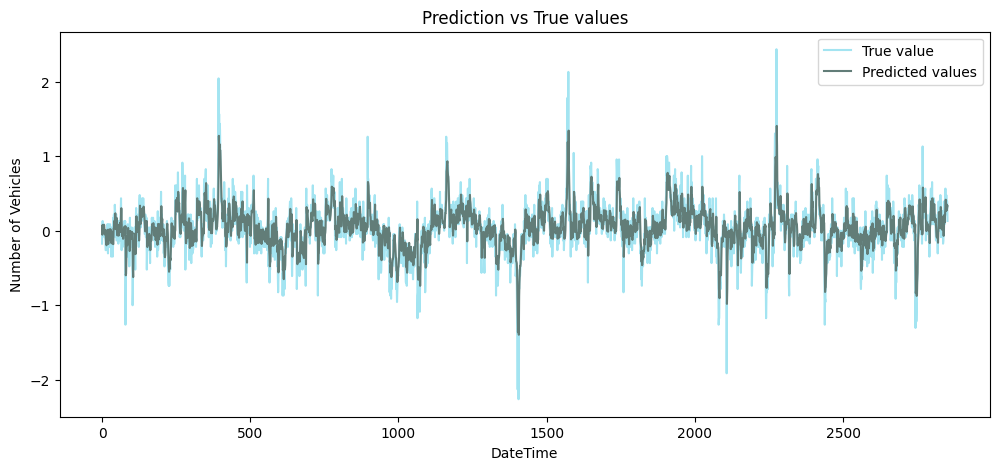

In [49]:
pred_rnn = rnn_model(X_train, y_train, X_test, early_stopping)
rmse_rnn = rmse_value(y_test, pred_rnn)
prediction(y_test, pred_rnn, 0)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                10400     
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
77/77 [==============================] - 4s 39ms/step - loss: 0.0616
Epoch 2/50
77/77 [==============================] - 3s 44ms/step - loss: 0.0461
Epoch 3/50
77/77 [==============================] - 5s 66ms/step - loss: 0.0427
Epoch 4/50
77/77 [==============================] - 3s 37ms/step - loss: 0.0424
Epoch 5/50
77/77 [==============================] - 3s 37ms/step - loss: 0.0422
Epoch 6/50
77/

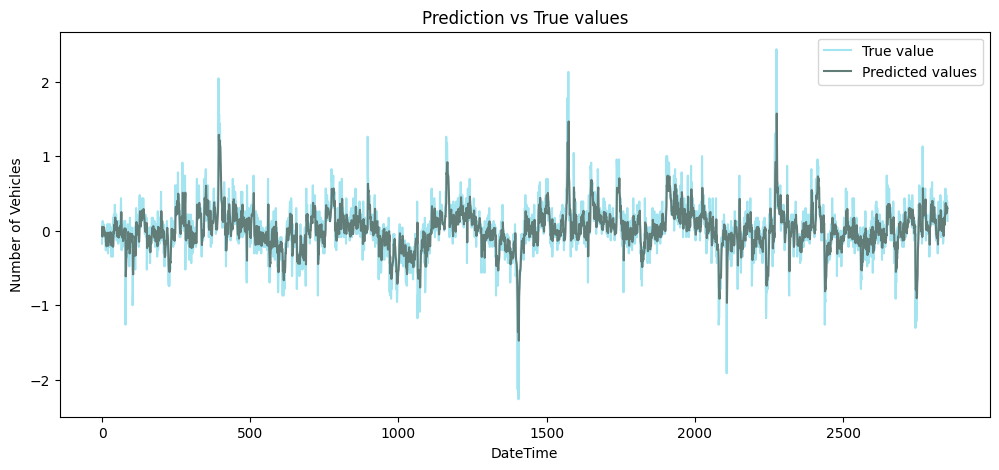

In [50]:
pred_lstm = lstm_model(X_train, y_train, X_test, early_stopping)
rmse_lstm = rmse_value(y_test, pred_lstm)
prediction(y_test, pred_lstm, 0)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 50)                7950      
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 8001 (31.25 KB)
Trainable params: 8001 (31.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
77/77 [==============================] - 4s 27ms/step - loss: 0.0586
Epoch 2/50
77/77 [==============================] - 2s 28ms/step - loss: 0.0430
Epoch 3/50
77/77 [==============================] - 2s 28ms/step - loss: 0.0422
Epoch 4/50
77/77 [==============================] - 3s 33ms/step - loss: 0.0420
Epoch 5/50
77/77 [==============================] - 5s 61ms/step - loss: 0.0419
Epoch 6/50
77/77

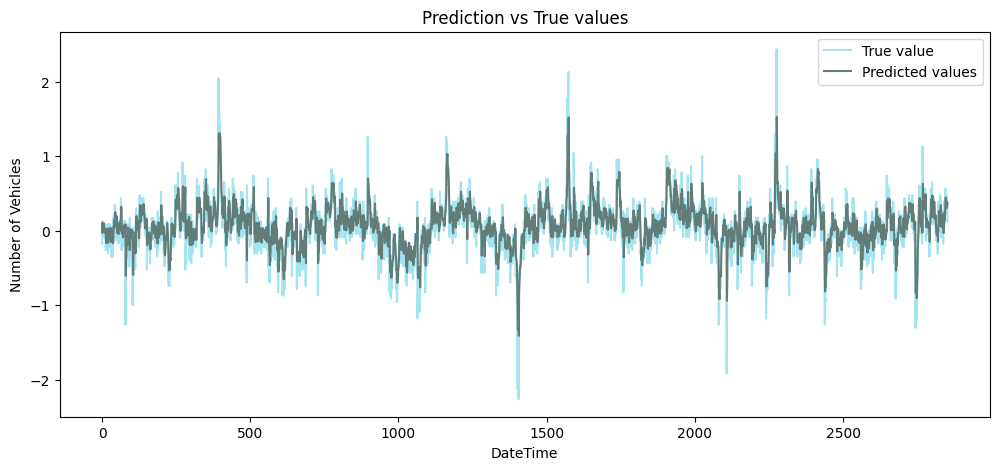

In [51]:
pred_gru = gru_model(X_train, y_train, X_test, early_stopping)
rmse_gru = rmse_value(y_test, pred_gru)
prediction(y_test, pred_gru, 0)

In [52]:
# membuat list RMSE setiap model
Junctions = ["RNN", "LSTM", "GRU"]
RMSE = [rmse_rnn, rmse_lstm, rmse_gru]
list_of_tuples = list(zip(Junctions, RMSE))

Results = pd.DataFrame(list_of_tuples, columns=["Junction", "RMSE"])
Results.style.background_gradient(cmap="Pastel1")


,Junction,RMSE
0,RNN,0.234206
1,LSTM,0.234441
2,GRU,0.235834
